## Finite Element Method (FEM) discretization of the Poisson equation in two dimensions with FEniCS

<b>Goal</b>: This <a href="https://jupyter.org"> Jupyter</a> notebook aims at illustrating the use of FEniCS to discretize a Poisson equation in two dimensions. We specifically learn how to define the problem inside FEniCS. 

<b>Note</b>: a cell is made active by first clicking on the left part of the web page (a blue vertical line appears) and then pushing Shift+Enter. 

<b>Note</b>: The next cell has to be activated only once and specifies the Python libraries we will use in this notebook. A basic knowledge of Python is only expected to understand the code used in the cells.  

In [1]:
#
# To allow plots within the Notebook 
#
%matplotlib inline
#
# Import here the standard Python libraries used in the Notebook
#
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
import scipy.sparse as sps
import sys
import time
#
# Import FEniCS related libraries
#
from fenics import *
import dolfin as df

### Python version

In [2]:
print(sys.version)

3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 15:43:19) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### <a href="https://fenicsproject.org">FEniCS</a> version 

In [3]:
print(df.__version__)

2019.1.0


### <a href="https://fenicsproject.org">Scipy</a> Linear algebra libraries

In [4]:
print(show_config())

mkl_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
system_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
None


# A.  2D Poisson equation:


We consider the two-dimensional Poisson equation with non-homogeneous Dirichlet boundary conditions defined as
$$
\begin{array}{ll} 
     - \text{div}\Big(\overline{\overline k}(\boldsymbol x)\cdot {grad} \ u(\boldsymbol x)\Big)&=& f , \quad \boldsymbol x \in \Omega, \\
    u(\boldsymbol x) & = & u_D(x), \quad \boldsymbol x \in \delta \Omega,  \\
\end{array}
$$
with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega$. 

$u(\boldsymbol x)$ denotes the solution at point $\boldsymbol x \in \Omega $, $u_D$ the Dirichlet condition defined on $\boldsymbol x \in \partial \Omega$.  $\overline{\overline k} \in L^{\infty}(\Omega)$ (symmetric and coercive) denotes the tensor related to the conductivity. 


<b>Structure of this part </b>: This notebook first defines the continuous problem by using specific routines of FEniCS. Then we tackle the finite element discretization in space of the PDE. This discretization leads to a linear system that is solved with a direct solution method. Finally a simple postprocessing is performed. 

<b>Methodology</b>: To validate our implementation, we use the method of manufactured solutions. This means that we impose a solution to the PDE above (satisfying the  boundary conditions) and analytically compute the corresponding source term $f$. We later check that the computed solution is in agreement with the imposed solution. 

### Constants and parameters 

In [5]:
#
# Define constants related to the definition of the geometric rectangular domain
# x0, y0 are the coordinates of the bottom left point of the rectangle
# xL, yL are the coordinates of the top right point of the rectangle
#
x0, xL, y0, yL = 0., 2., 0., 1.
#
# Number of rectangle elements to be used in each direction for the mesh construction
#
nx = 50
ny = 40
#
# Degree of Lagrange approximation in space
#
deg = 2 
#
# Specify if the solution has to be stored in a png file for post-processing 
#
store = True
#
# Boolean variable
#
check = True

### FEniCS expressions definition
To define a function, the simplest way is to use a FEniCS Expression, which expresses the formula for the function in terms of the coordinates of the point (here x[0] and x[1] in two dimensions). When applicable, the second possibility is to use a FEniCS Constant statement.  

In [6]:
#
# Define Fenics Expressions or Constants
#

# Piecewise constant conductivity coefficient, with possibly a high conductivity in a subrectangle
#
# To specify k we use a FEniCS Expression which expresses the formula in terms of the coordinates
# of the point. The expression is a string that is parsed by a C++ compiler and so must be written in C++.
# degree is the degree of quadrature to be used later for k in the assembly process. 

k  = Expression('x[0] + x[1]',degree=2)

# We give here a more involved example for defining k with variable values in the domain. 
# DOLFIN_EPS is the machine precision used in FEniCS.
# Here we specify two different subdomains and may assign different values depending on the location. 
# k  = Expression("x[0] > .5 - DOLFIN_EPS && x[0] < 1.25 + DOLFIN_EPS && x[1] < .75 + DOLFIN_EPS && x[1] > .5 - DOLFIN_EPS ? 100. : 1.", degree=4)
#
# Source term
# We use a Constant here due to the definition of the source term.
#
f  = Constant(0.)
if check: f  = Expression('-8.*x[0] - 10.*x[1]',degree=2)

#
# Expression related to the exact solution
#
u_E = Expression("10.*exp(-((x[0]-0.5*Lx)*(x[0]-0.5*Lx)+(x[1]-0.5*Ly)*(x[1]-0.5*Ly)))", degree=2, Lx=xL, Ly=yL)

if check: u_E = Expression("1+x[0]*x[0]+2*x[1]*x[1] ", degree=2)

#
# This function is useful later for the treatment of the Dirichlet boundary condition in FEniCS
#
def Gamma_D(x, on_boundary):
    """
    This function should return a boolean value equal to true or false according to whether the point x 
    belongs to Gamma_D or not. 
    """
    # Here we simply use the "on_boundary" boolean provided by FEniCS since the 
    # Dirichlet condition is imposed on the whole boundary of the domain.
    return on_boundary

### Problem at the continuous level

We seek a function $u$ in a trial space $V$ such that:
\begin{equation}
a(u,v) = l(v), \; \text{for all test functions} \; v \in V, \text{such as} \; v=0 \; \text{on} \; \delta \Omega, \\
\end{equation}
where the bilinear form $a: V \times V \rightarrow \mathbb{R}$ and the linear functional $l: V \rightarrow \mathbb{R}$ are given by:
\begin{equation}
a(u,v) = \int_{\Omega} k \, \nabla{u}\, . \, \nabla{v} dx, \quad l(v)= \int_{\Omega} f v dx.
\end{equation}

### Problem at the discrete level in space
FEniCS's Unified Form Language (UFL) greatly simplifies the definition of the bilinear and linear forms at the discrete level as seen next.

Checking symmetry  1.7627073854183126e-16
Dimension of A:  (16181, 16181)
Number of non-zeros of A:  184721
Time spent in the meshing procedure:  0.0009063639999999928
Time spent in the finite element assembly procedure:  0.16068792499999995


Text(0.5, 1.05, 'Sparsity pattern of A')

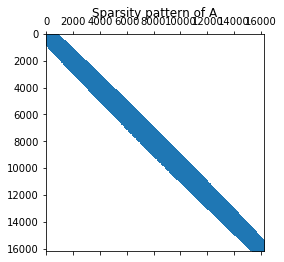

In [7]:
#
# Finite Element Space discretization of the weak formulation
# 
  
# Generate the computational mesh 
# Here is the simplest way to discretize a rectangular domain with nx and ny rectangles in directions x and y,
# respectively. 
# The 'crossed' argument specifies that each rectangle will be divided into four triangles. 
# We also evaluate the computational time related to this operation.

meshing_start         = time.perf_counter()
mesh                  = RectangleMesh(Point(x0,y0), Point(xL,yL), nx, ny,'crossed')
meshing_time          = time.perf_counter()-meshing_start

# If the domain is the unit square, you may want to use instead
# mesh = UnitSquareMesh(nx, ny, 'crossed')
    
# Select the FE approximation space of Lagrange type

Vh = FunctionSpace(mesh, "Lagrange", deg)
 
#    
# Discretization in space of the weak formulation 
#
assembly_start = time.perf_counter()

#
# The next two lines define two arguments that can be used as variables 
# to define the bilinear form (u as first argument, v as second)
#
u  = TrialFunction(Vh)
v  = TestFunction(Vh)

#
# Definition of the variational formulation a and l with UFL specific to FEniCS
#
a  = k*inner(grad(u), grad(v))*dx 
l  = f*v*dx

# Specify the constraints related to the Dirichlet boundary conditions

bc = DirichletBC(Vh, u_E, Gamma_D)


# Strategy I: 
#
# Get the solution directly from the solve FEniCS command
# with these two lines
# 

# The next line defines uh as a function of the finite element space Vh. Such a function 
# is characterized by a vector of length dim(Vh) giving the values of the its degrees 
# of freedom. Such a vector can be obtained as uh.vector() which has the type of a FEniCS
# vector. 

uh     = Function(Vh)

# The next line performs several actions. First the bilinear form a is assembled into a sparse 
# matrix and the linear functional into a vector. The resulting linear system is solved and
# the solution is stored as the degrees of freedom of the function uh. Note that the bc 
# variable specifies the essential boundary condition. 
#
#

solve(a == l, uh, bc)

# Strategy II:
# 
# This strategy offers more control on the choice of solution methods.
#
# Deduce the linear system of equations if A and b need to be stored. 
# Note that assemble_system keeps the symmetry of A when taking into account the essential 
# boundary conditions.
# A is a FEniCS Matrix object. A.array() will convert A to a full matrix stored as 
# a numpy array.
# b is a FEniCS Vector object.

A, b = assemble_system(a,l,bc)

assembly_time = time.perf_counter()-assembly_start

#
# Checking symmetry of A that must be satisfied due to the use of assemble_system
#
# Note that the use of assemble does not maintain symmetry.
#
R = A.array() - A.array().T
print("Checking symmetry ",np.linalg.norm(R,1)/np.linalg.norm(A.array(),1))

# Construct the solver object related to the implicit part of the discretization
# We perform here a Gaussian factorization of A and specify that A is symmetric.

Asolve                            = LUSolver(A,method='mumps')
Asolve.parameters['symmetric']    = True  

#
# Timings
#

print("Dimension of A: ",A.array().shape[:])
print("Number of non-zeros of A: ",A.nnz())
print("Time spent in the meshing procedure: ",meshing_time)
print("Time spent in the finite element assembly procedure: ",assembly_time)

#
# Sparsity pattern of A
# 

plt.figure()
plt.spy(sps.csr_matrix(A.array()))
plt.title("Sparsity pattern of A")

### Numerical approximation of the space solution

In [8]:
#
# Strategy I: 
#
# The call to solve as solve(a == l, uh, bc) in the cell above has already delivered 
# the solution in the function uh. 
#

#
# Solution of the linear system with Strategy II: we apply the solve method of a given solver
# to deduce the solution. In this solve command, only vectors must be passed.  
#
wh                     = Function(Vh)
#
#
#
solution_start         = time.perf_counter()
Asolve.solve(wh.vector(), b)
solution_time          = time.perf_counter()-solution_start

#
# Statistics
# 
print("Time spent in the factorization and solution phase: ",solution_time)

Time spent in the factorization and solution phase:  0.19936335399999905


### Post-processing

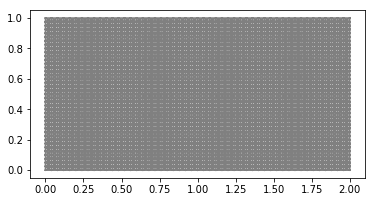

In [9]:
#
# We plot the finite element mesh
# 
plot(mesh)

Text(0.5, 1.0, 'Solution of the heterogeneous Poisson equation')

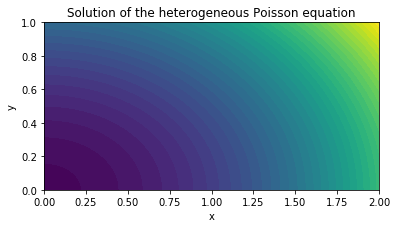

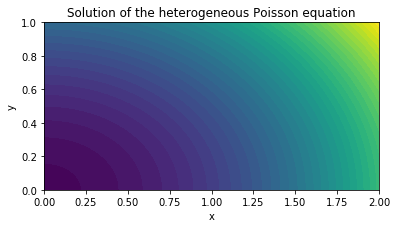

In [10]:
#
# A very basic post-processing
# We plot the solution in the computational domain, plot requires the function only. 
#
plt.figure()
plot(wh)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the heterogeneous Poisson equation')
plt.figure()
plot(uh)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the heterogeneous Poisson equation')

 
#
# Store the file if required
#

## Task: 

Modify the above code to solve the heterogeneous Poisson equation with exact solution $u_E(x,y) = 1 + x^2 + 2 y^2$ and $k(x,y) = x + y$. The Dirichlet boundary condition is imposed on the whole boundary as above. The right-hand side of the equation is given by $-8x-10y$. Check the result of your implementation by calculating the $L_2$ norm of the error between the exact solution $u_E$ and the computed solution $u_h$ by calling the errornorm function provided in FEniCS. The boolean variable check should be set to True in the "Constants and parameters" cell.  

In [11]:
if check: print(errornorm(u_E,uh))

2.1354728266673163e-14


### Feedback / Your comments or notes

# Further information

- <a href="https://fenicsproject.org">FEniCS website</a>. 

- <a href="https://fenicsproject.org/tutorial">FEniCS tutorials</a>.